<h1> Speech Rap Signing Classification - LSTM</h1>

Source: https://www.youtube.com/watch?v=4nXI0h2sq2I&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=19

Data source: see my SRS_classifier.ipynb notebook

In [1]:
import numpy as np
import json

<h2>Data Preperation</h2>

We use the same MFCC data drawn at 16000 samples per second as we generated for the multi-layer perceptron approach used previously (see SRS_classifier.ipynb).

Data structure:

$x.\texttt{shape}=(\text{num samples},\text{num time intervals}, \text{num MFCC variables})$

$x_i.\texttt{shape} = (\text{num time intervals}, \text{num mfcc variables}))$


$y.\texttt{shape}=(\text{num labels})$

$y_i=\text{label}$

where $\text{label} \in \{1,2,3\}$

In [2]:
#load data from the file
#split data into training and test
"""
load data from a json file with objects "mfcc" and "labels"
@param dataset_path: path to the json file
@return np array of mfcc data, np array of target values
"""
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
        inputs=np.array(data["mfcc"])
        targets=np.array(data["labels"])
        return inputs,targets


<h3>Load the data</h3>
Load the data from the jason file and verify that the inputs are of the expected type, and the sample size is as expected, in this case: 480 samples of each label.


In [3]:
x,y = load_data("data.json")
print ("input shape", x.shape)

unique_elements, counts_elements = np.unique(y, return_counts=True)
print("Frequency of unique values of the targets:")
print(np.asarray((unique_elements, counts_elements)))

input shape (1440, 94, 13)
Frequency of unique values of the targets:
[[  0   1   2]
 [480 480 480]]


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.1)

In [5]:
x_train.shape

(1166, 94, 13)

In [6]:
import tensorflow.keras as keras
import tensorflow as tf

"""
Creates a model of three pooled convolutional layers, followed by a single fully connected layer and an output layer.
@param input_shape: the structure of SINGLE value x_i (omits the first dimension of x which is the total number of samples.)
@return uncompiled keras model of the CNN.
"""
def build_model(input_shape,dropoutRate=0):
    model=keras.Sequential()
    
    #LSTM Layer 1
    #return_sequences = True: sequence to sequence layer, otherwise sequence to vector
    model.add(keras.layers.LSTM(units=64,activation='tanh',input_shape=input_shape,return_sequences=True))
    #LSTM Layer 2
    model.add(keras.layers.LSTM(units=64,activation='tanh',input_shape=input_shape,return_sequences=False))
    
    #pipe output into a dense layer. No need to flatten because sequence to vector
    model.add(keras.layers.Dense(units=64,activation='relu'))
    model.add(keras.layers.Dropout(dropoutRate))
    
    #output layer
    #a fully connected layer for classification
    NUMBEROFPOSSIBLEOUTPUTS=3
    model.add(keras.layers.Dense(NUMBEROFPOSSIBLEOUTPUTS,activation='softmax'))
    return model

In [7]:
#each sample has the shape (num samples,intervals,variables,channels=1)
input_shape=(x_train.shape[1], x_train.shape[2])
model = build_model(input_shape,dropoutRate=0.4)

#model.summary()

In [8]:
#Adam is a very very effecting sgd variant for deep learning
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#put all the components together
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"]
              )

In [9]:
#stores the progression of several metrics as the model trains.
history = model.fit(x_train,y_train,validation_data=(x_validation,y_validation),epochs=50)

Epoch 1/50
37/37 [==============================] - 2s 43ms/step - loss: 1.0785 - accuracy: 0.4057 - val_loss: 0.9942 - val_accuracy: 0.5462
Epoch 2/50
37/37 [==============================] - 1s 26ms/step - loss: 0.9821 - accuracy: 0.5489 - val_loss: 0.8823 - val_accuracy: 0.7154
Epoch 3/50
37/37 [==============================] - 1s 26ms/step - loss: 0.8802 - accuracy: 0.6509 - val_loss: 0.7449 - val_accuracy: 0.7462
Epoch 4/50
37/37 [==============================] - 1s 26ms/step - loss: 0.7592 - accuracy: 0.6973 - val_loss: 0.6239 - val_accuracy: 0.7692
Epoch 5/50
37/37 [==============================] - 1s 26ms/step - loss: 0.7002 - accuracy: 0.7273 - val_loss: 0.5730 - val_accuracy: 0.7846
Epoch 6/50
37/37 [==============================] - 1s 27ms/step - loss: 0.6288 - accuracy: 0.7616 - val_loss: 0.5034 - val_accuracy: 0.8231
Epoch 7/50
37/37 [==============================] - 1s 26ms/step - loss: 0.5469 - accuracy: 0.8045 - val_loss: 0.4624 - val_accuracy: 0.8385
Epoch 8/50
37

In [11]:
import pyaudio
import wave

In [34]:


CHUNK = 512
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
RECORD_SECONDS = 3
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
    
    

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


In [35]:
print(len(data))
print(len(frames))

1024
93


In [36]:
frame_array=np.array(frames)
import librosa
signal, sr = librosa.load("output.wav",sr=RATE)


In [37]:
mfcc_data={'mfcc':[], 'labels':[]}

In [38]:
import math

n_mfcc=13
n_fft=2048
hop_length=512

mfcc=None
samples_per_track=RATE * RECORD_SECONDS
num_samples_per_segment=int(samples_per_track)
expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment/ hop_length)

#the mfcc for data points between start_sample and finish_sample
mfcc = librosa.feature.mfcc(signal,sr=sr,n_fft=n_fft,n_mfcc=n_mfcc, hop_length = hop_length)
mfcc=mfcc.T
#store mfcc for segement if it has the expected length
if len(mfcc)==expected_num_mfcc_vectors_per_segment:
    mfcc_data["mfcc"].append(mfcc.tolist())
    mfcc_data["labels"].append("unknown")

In [39]:
print("expected_num_mfcc_vectors_per_segment",expected_num_mfcc_vectors_per_segment)
print()

expected_num_mfcc_vectors_per_segment 94



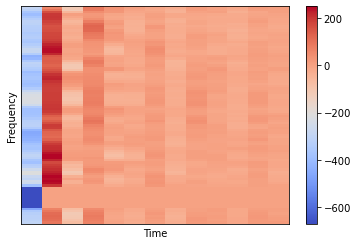

In [40]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import librosa.display

librosa.display.specshow(mfcc, sr=sr, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()

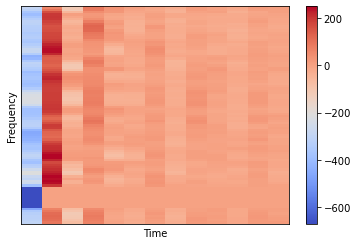

In [41]:
np_mfccData = np.array(mfcc_data['mfcc'])
librosa.display.specshow(np_mfccData[0], sr=sr, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()

In [42]:
#model expects [n,94,13]
np_mfccData.shape

(1, 94, 13)

In [43]:
prediction=model.predict(np_mfccData)
print ("prediction ",prediction)
maxArg=np.argmax(prediction)
print("maxArg",maxArg)
possible=["rap","singing","speech"]
print (possible[maxArg])

prediction  [[0.00329802 0.6099867  0.3867153 ]]
maxArg 1
singing
